In [119]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as sym
from collections import namedtuple

In [120]:
def f1(x,y,a=1,b=5):
    return a*np.abs(x) + b*np.abs(y)

def gf1(x,y,a=1,b=5):
    sx, sy = np.sign(x), np.sign(y)
    return np.array([a*sx,b*sy])

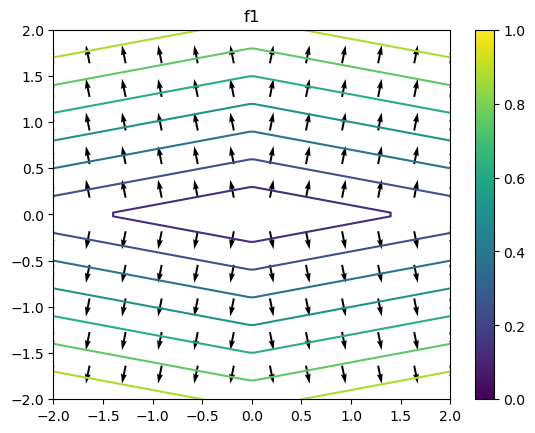

In [121]:
plt.tight_layout()

x_axis = np.linspace(-2,2, 100)
X,Y = np.meshgrid(x_axis,x_axis)
plt.contour(X,Y,f1(X,Y))

xg_axis = np.linspace(-2,2, 12)
Xg,Yg = np.meshgrid(xg_axis,xg_axis)
plt.quiver(Xg,Yg,*gf1(Xg,Yg))

plt.title("f1")
plt.colorbar()

In [193]:
Result_ellipsoid_B = namedtuple('Result_ellipsoid_B', 'x_opt, stop_reason, xk, Bk, fk, gk, rk, hk, xik') 

def ellipsoid_B(f, gf, x0, eps, timeout=1000, r0=1.0, lambd=1.0):
    n = x0.shape[0]
    xk = []
    Bk = []
    fk = []
    gk = []
    hk = []
    rk = []
    xik = []

    SR_TIMEOUT, SR_SUBGRAD, SR_DX, SR_OTHER = 'timeout', 'gk_lt_eps', 'dx_lt_eps', 'other'
    stop_reason = SR_TIMEOUT

    B_coef = (np.sqrt((n-1)/(n+1)) - 1)
    r_coef = (n/np.sqrt(n*n-1))/lambd
    h_coef = 1/(n+1)
    assert r_coef < 1+eps
    assert h_coef < 1+eps

    k = 0
    x_cur = x0
    B_cur = np.eye(n)
    f_cur = f(*x0)
    g_cur = gf(*x0)
    r_cur = r0
    h_cur = r0/(n+1)
    xi_prev = np.zeros(n)

    def append_hist(_xk,_Bk,_fk,_gk,_rk,_hk,_xik):
        xk.append(_xk)
        Bk.append(_Bk)
        fk.append(_fk)
        gk.append(_gk)
        rk.append(_rk)
        hk.append(_hk)
        xik.append(_xik)
        

    while k<timeout:
        append_hist(x_cur, B_cur, f_cur, g_cur, r_cur, h_cur, xi_prev)

        _xi_cur = B_cur.T @ g_cur
        _xi_cur_norm = np.linalg.norm(_xi_cur)
        
        xi_cur = _xi_cur / _xi_cur_norm
        _Bxi = B_cur @ xi_cur
        
        if r_cur * _xi_cur_norm < eps:
            stop_reason = SR_SUBGRAD
            break
        
        # if (np.abs(_Bxi) * h_cur < eps).any():
        #     stop_reason = SR_DX
        #     break
        
        x_next = x_cur - h_cur * _Bxi
        assert _Bxi.shape == (n,)
        _Bxi_xiT = np.outer(_Bxi, xi_cur)
        assert _Bxi_xiT.shape == (n,n)
        B_next = lambd * (B_cur + B_coef * _Bxi_xiT )
        r_next = r_coef * r_cur
        h_next = h_coef * r_next

        x_cur, B_cur, f_cur, g_cur, r_cur, h_cur, xi_prev = \
            x_next, B_next, f(*x_next), gf(*x_next), r_next, h_next, xi_cur
        k+=1
    
    xik = xik[1:] + [xi_cur]

    return Result_ellipsoid_B(x_cur, stop_reason, xk, Bk, fk, gk, rk, hk, xik)

### Функція f1.
$x^* = (0,0)$  
$f^* = 0$

In [418]:
x0 = np.array([1.0,1.0])
r0 = 2.0
lambd = 10

result1 = ellipsoid_B(f1, gf1, x0, eps=1e-8, timeout=1000, r0=r0, lambd=lambd)
result1.x_opt, result1.stop_reason, len(result1.xk)

(array([-1.95267012e-09, -3.60108318e-10]), 'gk_lt_eps', 147)

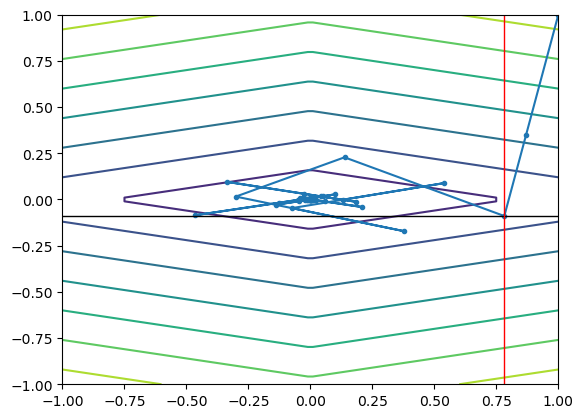

In [419]:
x_axis = np.linspace(-1,1, 100)
X,Y = np.meshgrid(x_axis,x_axis)
plt.contour(X,Y,f1(X,Y))

plt.plot(*np.array(result1.xk).T, '.-');
plt.axhline(result1.xk[2][1], c='k', lw=1)
plt.axvline(result1.xk[2][0], c='r', lw=1)

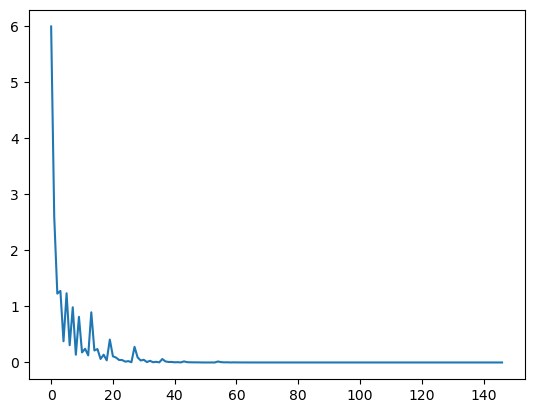

In [420]:
plt.plot(result1.fk)

In [421]:
result1.xk[2]

array([ 0.78209318, -0.08953408])

In [422]:
R = result1.Bk[2]**(-1)

In [423]:
XY = np.array([X.flatten(),Y.flatten()])
XY.shape

(2, 10000)

In [424]:
GX, GY = R.dot(XY)
GX = GX.reshape(100,100)
GY = GY.reshape(100,100)

(GX[17,17], GY[17,17]), (R @ np.array([X[17,17], Y[17,17]]))

((0.04447368421052632, 0.03292207792207792), array([0.04447368, 0.03292208]))

In [425]:
result1.xik[2]

array([ 0.64319209, -0.76570486])

In [426]:
hline = np.zeros((2,100))
hline[0] = x_axis
hline[1] = result1.xk[2][1]
Ghline = R @ hline

vline = np.zeros((2,100))
vline[0] = result1.xk[2][0]
vline[1] = x_axis
Gvline = R @ vline

xi = result1.xik[2]
Gx = np.array([R @ result1.xk[i] for i in range(4)]).T
Gx

array([[-0.06773684, -0.01808849,  0.0150104 , -0.01637723],
       [-0.05014286, -0.0581556 , -0.06349743, -0.00439182]])

Text(0.5, 1.0, 'f1 and xi in modified coords')

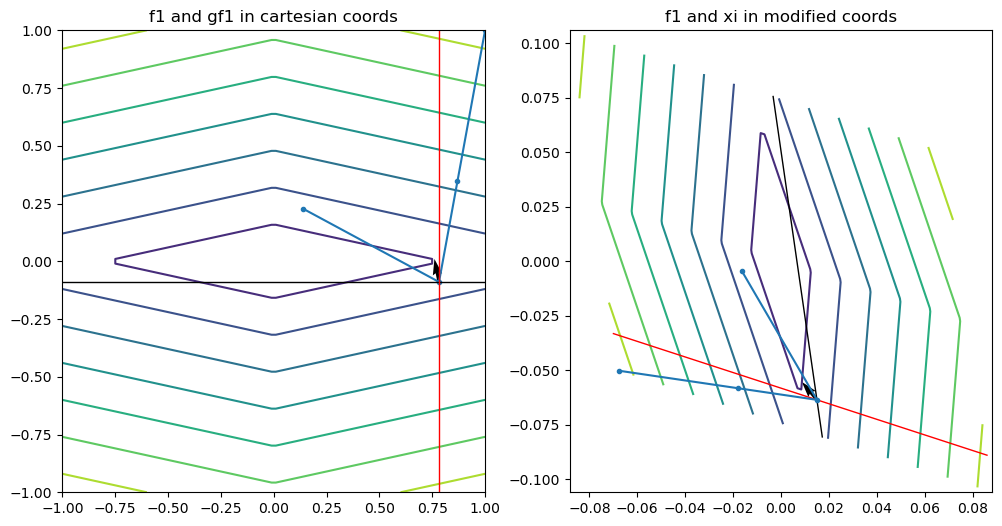

In [427]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(12,6)

x_axis = np.linspace(-1,1, 100)
X,Y = np.meshgrid(x_axis,x_axis)
ax1.contour(X,Y,f1(X,Y))

ax1.plot(*np.array(result1.xk[:4]).T, '.-');
ax1.quiver(*result1.xk[2], *-gf1(*result1.xk[2]))
ax1.axhline(result1.xk[2][1], c='k', lw=1)
ax1.axvline(result1.xk[2][0], c='r', lw=1)
ax1.set_title("f1 and gf1 in cartesian coords")

ax2.contour(GX,GY,f1(X,Y))
ax2.plot(*Ghline, c='k', lw=1)
ax2.plot(*Gvline, c='r', lw=1)
ax2.plot(*Gx, '.-')
ax2.quiver(*Gx[:,2], *-xi)
ax2.set_title("f1 and xi in modified coords")

### Функція f2.
$x^* = (0,2-\sqrt{2}) \approx (0,0.5858)$  
$f^* = 6-4\sqrt{2} \approx 0.3431$

https://www.wolframalpha.com/input?i=minimum+of+max%28x%5E2+%2B+y%5E2%2C+2x%5E2+%2B+2%28y-1%29%5E2%29  
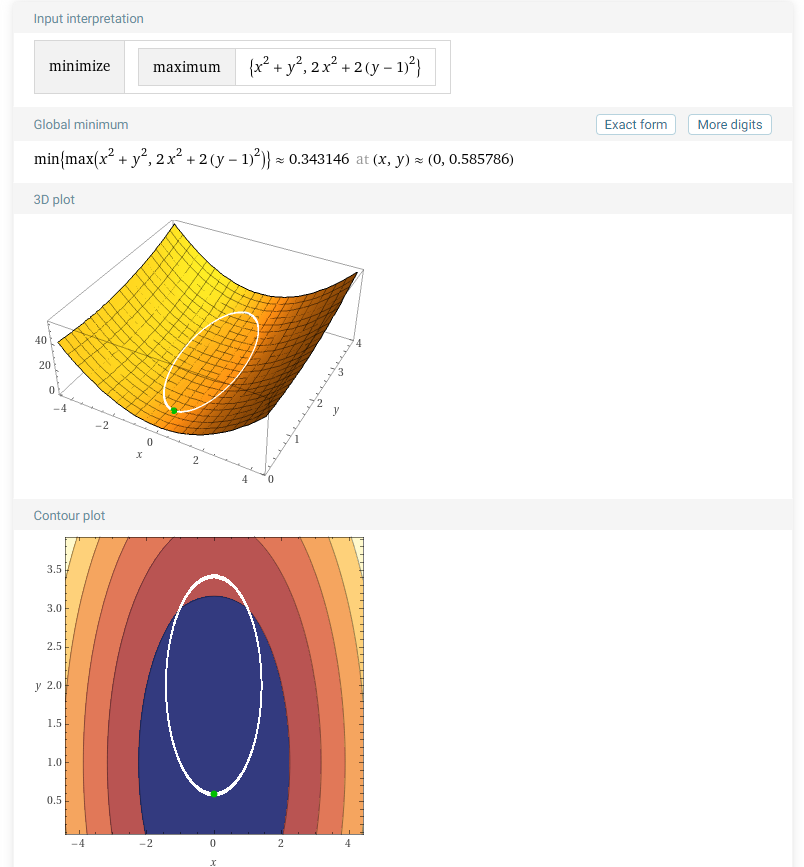

In [197]:
def f2(x,y):
    return np.maximum(
        x**2 + y**2,
        2*(x**2 + (y-1)**2)
    )

def gf2(x,y,eps=1e-9):
    if x**2 + y**2 - 4*y + 2 >= 0:
        return 4*np.array([x,y-1])
    return 2*np.array([x,y])

def df2_vec(x,y,eps=1e-9):
    scnd = (x**2 + y**2 - 4*y + 2 >= 0)
    shp = (2,*scnd.shape)
    result = np.zeros(shp)
    result[:,scnd] = 4*np.array([x[scnd],y[scnd]-1])
    result[:,~scnd] = 2*np.array([x[~scnd],y[~scnd]])
    return result

0.35047706401494394


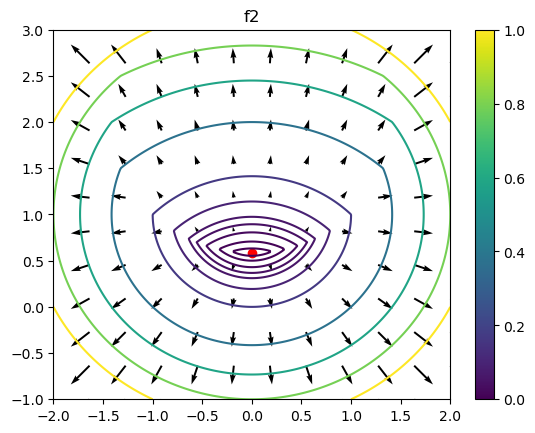

In [211]:
# plt.tight_layout()

x_axis = np.linspace(-2,2, 300)
y_axis = np.linspace(-1,3, 300)
X,Y = np.meshgrid(x_axis, y_axis)
levels = [0.4,0.5,0.65,0.8,0.95,1.3,2,4,6,8,10]
Z = f2(X,Y)
print(Z.min())
plt.contour(X,Y,Z, levels)

xg_axis = np.linspace(-2,2, 12)
yg_axis = np.linspace(-1,3, 12)
Xg,Yg = np.meshgrid(xg_axis, yg_axis)
plt.quiver(Xg,Yg,*df2_vec(Xg,Yg))

plt.title("f2")
plt.colorbar()

plt.scatter(0, 2-np.sqrt(2), c='r')

In [390]:
x0 = np.array([1.5,1])
r0 = 1
lambd = 2

result2 = ellipsoid_B(f2, gf2, x0, eps=1e-8, timeout=1000, r0=r0, lambd=lambd)
result2.x_opt, result2.stop_reason, len(result2.xk)



(array([8.57624300e-06, 5.85786439e-01]), 'gk_lt_eps', 107)

0.35047706401494394


(-1.0, 3.0)

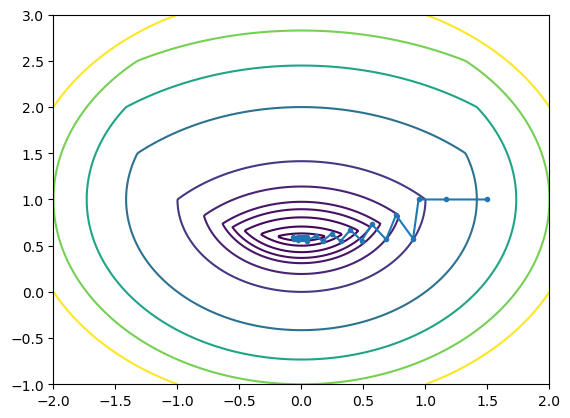

In [391]:
x_axis = np.linspace(-2,2, 300)
y_axis = np.linspace(-1,3, 300)
X,Y = np.meshgrid(x_axis, y_axis)
levels = [0.4,0.5,0.65,0.8,0.95,1.3,2,4,6,8,10]
Z = f2(X,Y)
print(Z.min())
plt.contour(X,Y,Z, levels)

plt.plot(*np.array(result2.xk).T, '.-');
plt.xlim(-2,2)
plt.ylim(-1,3)

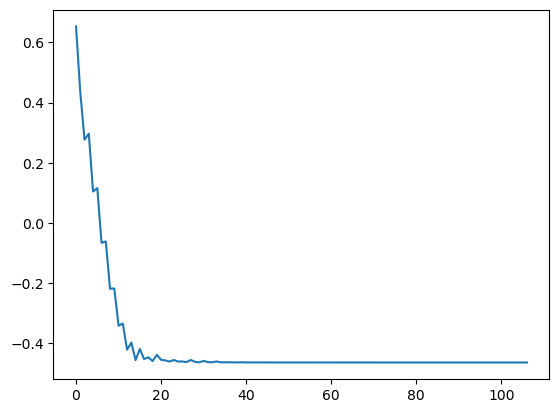

In [392]:
plt.plot(np.log10(result2.fk))

## Візуалізація

0.35047706401494394


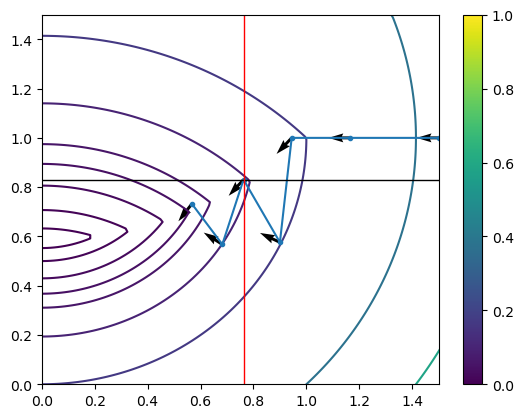

In [395]:
x_axis = np.linspace(-2,2, 300)
y_axis = np.linspace(-1,3, 300)
X,Y = np.meshgrid(x_axis, y_axis)
levels = [0.4,0.5,0.65,0.8,0.95,1.3,2,4,6,8,10]
Z = f2(X,Y)
print(Z.min())
plt.contour(X,Y,Z, levels)

plt.plot(*np.array(result2.xk)[:7].T, '.-');
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.axhline(result2.xk[4][1],c='k',lw=1)
plt.axvline(result2.xk[4][0],c='r',lw=1)

for i in range(7):
    plt.quiver(*result2.xk[i], * -gf2(*result2.xk[i]))

plt.colorbar()

In [396]:
result2.xk[4]

array([0.76246158, 0.83076211])

In [397]:
R = result2.Bk[4]**(-1)

In [398]:
XY = np.array([X.flatten(),Y.flatten()])
XY.shape

(2, 90000)

In [400]:
GX, GY = R.dot(XY)
GX = GX.reshape(300,300)
GY = GY.reshape(300,300)

(GX[17,17], GY[17,17]), (R @ np.array([X[17,17], Y[17,17]]))

((-1.882893075817227, -3.108721010083458), array([-1.88289308, -3.10872101]))

In [406]:
hline = np.zeros((2,300))
hline[0] = x_axis
hline[1] = result2.xk[4][1]
Ghline = R @ hline

vline = np.zeros((2,300))
vline[0] = result2.xk[4][0]
vline[1] = y_axis
Gvline = R @ vline

xi = result1.xik[4]
Gx = np.array([R @ result2.xk[i] for i in range(7)]).T
Gx

array([[2.22624649, 2.13774134, 2.0787379 , 1.29198777, 1.72105629,
        1.21892423, 1.48921037],
       [2.67601102, 2.11043602, 1.73338602, 1.60240136, 1.40245392,
        1.23188719, 1.05819073]])

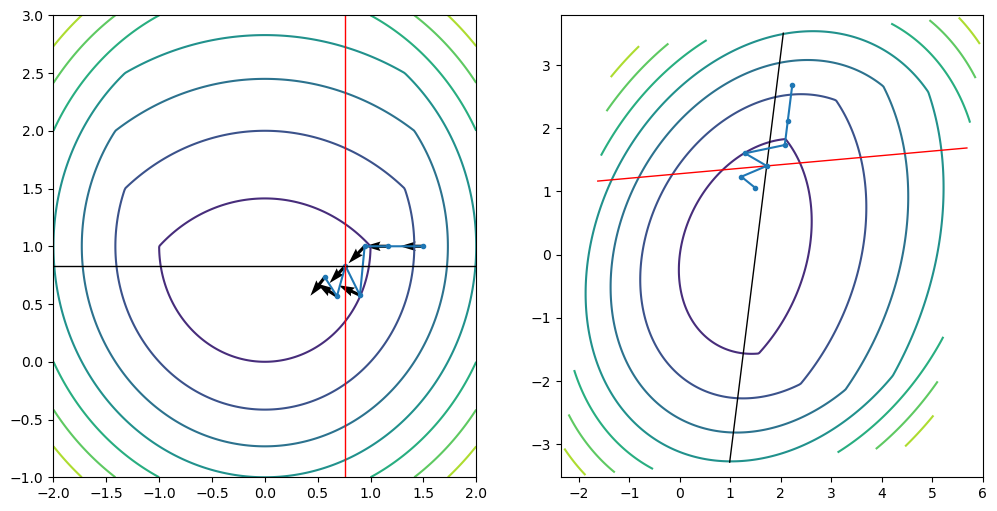

In [407]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,6)

# plt.contour(X,Y,f2(X,Y))
# plt.contour(X,2*Y,f2(X,2*Y))
ax2.contour(GX,GY,f2(X,Y))
ax2.plot(*Ghline, c='k', lw=1)
ax2.plot(*Gvline, c='r', lw=1)
ax2.plot(*Gx, '.-')

ax1.contour(X,Y,Z)

ax1.plot(*np.array(result2.xk)[:7].T, '.-');

ax1.axhline(result2.xk[4][1],c='k',lw=1)
ax1.axvline(result2.xk[4][0],c='r',lw=1)

for i in range(7):
    ax1.quiver(*result2.xk[i], * -gf2(*result2.xk[i]))


---

### Функція f3.
$x^* = (0,0)$  
$f^* = x^2 + y^2$

In [1]:
def f3(x,y):
    return x**2 + y**2

def df3(x,y):
    return 2*np.array([x,y])

In [ ]:
x0 = np.array([1.0,1.0])
r0 = 2.0
lambd = 2

result1 = ellipsoid_B(f1, gf1, x0, eps=1e-8, timeout=1000, r0=r0, lambd=lambd)
result1.x_opt, result1.stop_reason, len(result1.xk)

(array([-1.95267012e-09, -3.60108318e-10]), 'gk_lt_eps', 147)

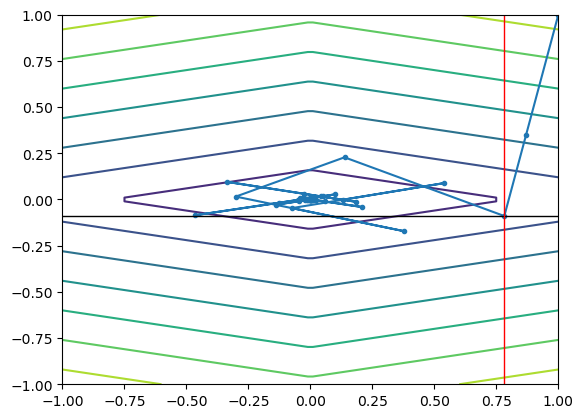

In [ ]:
x_axis = np.linspace(-1,1, 100)
X,Y = np.meshgrid(x_axis,x_axis)
plt.contour(X,Y,f1(X,Y))

plt.plot(*np.array(result1.xk).T, '.-');
plt.axhline(result1.xk[2][1], c='k', lw=1)
plt.axvline(result1.xk[2][0], c='r', lw=1)

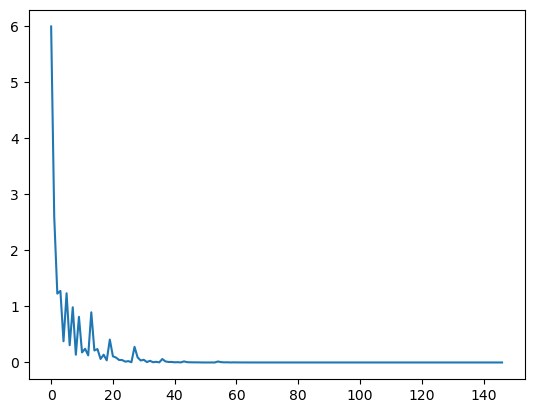

In [ ]:
plt.plot(result1.fk)

In [ ]:
result1.xk[2]

array([ 0.78209318, -0.08953408])

In [ ]:
R = result1.Bk[2]**(-1)

In [ ]:
XY = np.array([X.flatten(),Y.flatten()])
XY.shape

(2, 10000)

In [ ]:
GX, GY = R.dot(XY)
GX = GX.reshape(100,100)
GY = GY.reshape(100,100)

(GX[17,17], GY[17,17]), (R @ np.array([X[17,17], Y[17,17]]))

((0.04447368421052632, 0.03292207792207792), array([0.04447368, 0.03292208]))

In [ ]:
result1.xik[2]

array([ 0.64319209, -0.76570486])

In [ ]:
hline = np.zeros((2,100))
hline[0] = x_axis
hline[1] = result1.xk[2][1]
Ghline = R @ hline

vline = np.zeros((2,100))
vline[0] = result1.xk[2][0]
vline[1] = x_axis
Gvline = R @ vline

xi = result1.xik[2]
Gx = np.array([R @ result1.xk[i] for i in range(4)]).T
Gx

array([[-0.06773684, -0.01808849,  0.0150104 , -0.01637723],
       [-0.05014286, -0.0581556 , -0.06349743, -0.00439182]])

Text(0.5, 1.0, 'f1 and xi in modified coords')

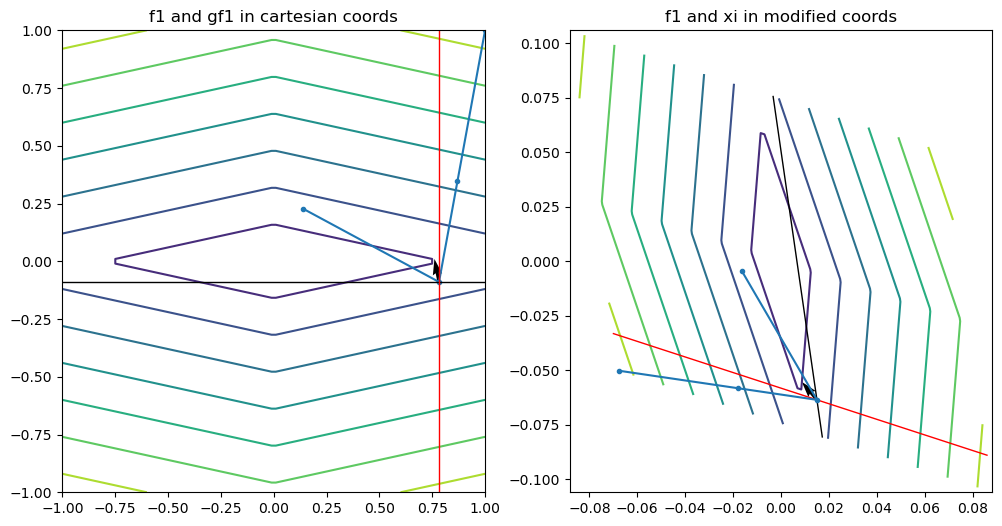

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(12,6)

x_axis = np.linspace(-1,1, 100)
X,Y = np.meshgrid(x_axis,x_axis)
ax1.contour(X,Y,f1(X,Y))

ax1.plot(*np.array(result1.xk[:4]).T, '.-');
ax1.quiver(*result1.xk[2], *-gf1(*result1.xk[2]))
ax1.axhline(result1.xk[2][1], c='k', lw=1)
ax1.axvline(result1.xk[2][0], c='r', lw=1)
ax1.set_title("f1 and gf1 in cartesian coords")

ax2.contour(GX,GY,f1(X,Y))
ax2.plot(*Ghline, c='k', lw=1)
ax2.plot(*Gvline, c='r', lw=1)
ax2.plot(*Gx, '.-')
ax2.quiver(*Gx[:,2], *-xi)
ax2.set_title("f1 and xi in modified coords")